<a href="https://colab.research.google.com/github/thaohh69/Coronavirus-2020-Visualization-Prediction/blob/master/ncov_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

In [2]:
!pip install plotly

In [3]:
!pip install folium

In [0]:
import plotly

In [0]:
#Graphical Libraries
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import folium
from folium.plugins import MarkerCluster, MiniMap, Fullscreen
import branca
from IPython.display import IFrame, YouTubeVideo


In [0]:
from plotly.offline import iplot

In [0]:
url_case = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_death = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_cured = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

In [0]:
confirmed = pd.read_csv(url_case)
recovered = pd.read_csv(url_cured)
deaths = pd.read_csv(url_death)

confirmed = np.sum(confirmed.iloc[:,4:confirmed.shape[1]])
recovered = np.sum(recovered.iloc[:,4:recovered.shape[1]])
deaths = np.sum(deaths.iloc[:,4:deaths.shape[1]])

global_mortality = deaths/(confirmed+recovered+deaths)*100


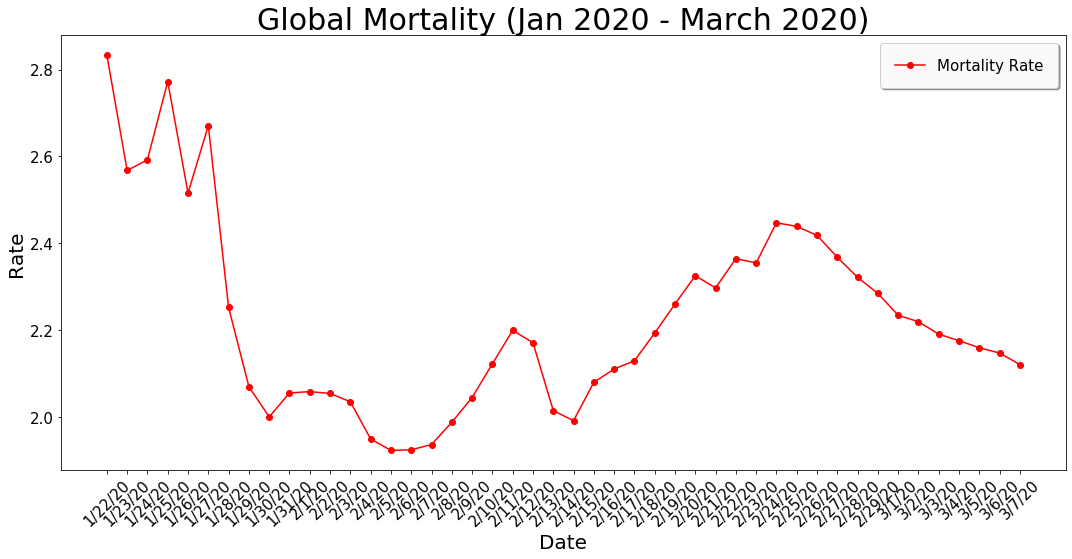

In [12]:
# defyning plotsize
plt.figure(figsize=(18,8))

# creating a lineplot for each case variable(suspected, recovered and death)
plt.plot(global_mortality
        , color = 'red'
        , label = 'Mortality Rate'
        , marker = 'o')

# defyning titles, labels and ticks parameters
plt.title('Global Mortality (Jan 2020 - March 2020)',size=30)
plt.ylabel('Rate',size=20)
plt.xlabel('Date',size=20)
plt.xticks(rotation=45,size=15)
plt.yticks(size=15)

# defyning legend parameters
plt.legend(loc = "upper right"
           , frameon = True
           , fontsize = 15
           , ncol = 1
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1);

### Create a function to transform 3 datasets

In [0]:
def load_csv(url, measure_name):
    df = pd.read_csv(url, index_col=[0, 1, 2, 3])
    df = df.stack()
    df = df.reset_index()
    
    cum = 'cum_' + measure_name
    df.columns = ['prov_state', 'country', 'lat', 'long', 'date', cum]
    
    df.date = pd.to_datetime(df.date, format='%m/%d/%y')
    
    df = df[df[cum] != 0]
    
    df['location'] = np.where(df.prov_state.isnull(), df.country, df.prov_state)
    
    new = 'new_' + measure_name
    df[new] = df.groupby('location')[cum].diff(1)
    df[new] = df[new].fillna(df[cum])
    
    return df[['location', 'prov_state', 'country', 'lat', 'long', 'date', cum, new]] # rearrange the columns and return the df

In [0]:
case = load_csv(url_case, 'case')
death = load_csv(url_death, 'death')
cured = load_csv(url_cured, 'cured')

In [15]:
case.shape

(3928, 8)

In [16]:
death.shape

(1053, 8)

In [17]:
cured.shape

(2137, 8)

In [0]:
# Merge into 1 dataframe.
df = pd.merge(case, death, how='left', on=['location', 'prov_state', 'country', 'lat', 'long', 'date'])
df = pd.merge(df, cured, how='left', on=['location', 'prov_state', 'country', 'lat', 'long', 'date'])

In [19]:
#Inspect Null Values
df.isnull().sum()

location         0
prov_state    1399
country          0
lat              0
long             0
date             0
cum_case         0
new_case         0
cum_death     2875
new_death     2875
cum_cured     1791
new_cured     1791
dtype: int64

In [20]:
df.dtypes

location              object
prov_state            object
country               object
lat                  float64
long                 float64
date          datetime64[ns]
cum_case               int64
new_case             float64
cum_death            float64
new_death            float64
cum_cured            float64
new_cured            float64
dtype: object

In [21]:
df.tail(10)

location             prov_state  ... cum_cured  new_cured
3918    Jackson County, OR     Jackson County, OR   ...       NaN        NaN
3919   Jefferson County, WA   Jefferson County, WA  ...       NaN        NaN
3920     Kershaw County, SC     Kershaw County, SC  ...       NaN        NaN
3921     Klamath County, OR     Klamath County, OR  ...       NaN        NaN
3922      Madera County, CA      Madera County, CA  ...       NaN        NaN
3923      Pierce County, WA      Pierce County, WA  ...       NaN        NaN
3924    Plymouth County, MA    Plymouth County, MA  ...       NaN        NaN
3925    Plymouth County, MA    Plymouth County, MA  ...       NaN        NaN
3926  Santa Cruz County, CA  Santa Cruz County, CA  ...       NaN        NaN
3927       Tulsa County, OK       Tulsa County, OK  ...       NaN        NaN

[10 rows x 12 columns]

In [22]:
df_last_update = df[df.date == '2020-03-07']
df_last_update.head()

location prov_state         country  ...  new_death  cum_cured new_cured
45       Anhui      Anhui  Mainland China  ...        0.0      979.0       0.0
91     Beijing    Beijing  Mainland China  ...        0.0      303.0       4.0
137  Chongqing  Chongqing  Mainland China  ...        0.0      526.0      13.0
183     Fujian     Fujian  Mainland China  ...        0.0      295.0      11.0
228      Gansu      Gansu  Mainland China  ...        0.0       87.0       0.0

[5 rows x 12 columns]

In [23]:
#Confirmed Case worldwide
df_last_update.cum_case.sum()
print('\n Confirmed cases worldwide: ',df_last_update.cum_case.sum())
print('\n Death cases worldwide: ',df_last_update.cum_death.sum())
print('\n Recovered cases worldwide: ',df_last_update.cum_cured.sum())


 Confirmed cases worldwide:  105836

 Death cases worldwide:  3558.0

 Recovered cases worldwide:  58359.0


In [24]:
#Countries affected
countries = df.country.unique().tolist()
print(countries)

print("Numbers of countries affected by nCov:", len(countries))

['Mainland China', 'Thailand', 'Japan', 'South Korea', 'Taiwan', 'US', 'Macau', 'Hong Kong', 'Singapore', 'Vietnam', 'France', 'Nepal', 'Malaysia', 'Canada', 'Australia', 'Cambodia', 'Sri Lanka', 'Germany', 'Finland', 'United Arab Emirates', 'Philippines', 'India', 'Italy', 'UK', 'Russia', 'Sweden', 'Spain', 'Belgium', 'Others', 'Egypt', 'Iran', 'Lebanon', 'Iraq', 'Oman', 'Afghanistan', 'Bahrain', 'Kuwait', 'Algeria', 'Croatia', 'Switzerland', 'Austria', 'Israel', 'Pakistan', 'Brazil', 'Georgia', 'Greece', 'North Macedonia', 'Norway', 'Romania', 'Denmark', 'Estonia', 'Netherlands', 'San Marino', 'Belarus', 'Iceland', 'Lithuania', 'Mexico', 'New Zealand', 'Nigeria', 'Ireland', 'Luxembourg', 'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan', 'Czech Republic', 'Armenia', 'Dominican Republic', 'Indonesia', 'Portugal', 'Andorra', 'Latvia', 'Morocco', 'Saudi Arabia', 'Senegal', 'Argentina', 'Chile', 'Jordan', 'Ukraine', 'Saint Barthelemy', 'Hungary', 'Faroe Islands', 'Gibraltar', 'Liechtenstein', '

In [25]:
print('\n Global confirmed cases: ',df.cum_case.sum())
print('\n Global death cases: ',df.cum_death.sum())
print('\n Global recovered cases: ',df.cum_cured.sum())


 Global confirmed cases:  2382656

 Global death cases:  70648.0

 Global recovered cases:  737378.0


In [26]:
# create map and display it
world_map = folium.Map(location=[10, -20], zoom_start=2.3,tiles='Stamen Toner')

for lat, lon, value, name in zip(df['lat'], df['long'], df['cum_case'], df['country']):
    folium.CircleMarker([lat, lon],
                        radius=10,
                        popup = ('<strong>Country</strong>: ' + str(name).capitalize() + '<br>'
                                '<strong>Confirmed Cases</strong>: ' + str(value) + '<br>'),
                        color='red',
                        
                        fill_color='red',
                        fill_opacity=0.7 ).add_to(world_map)
world_map

In [43]:
data = [ dict(
        type = 'choropleth',
        locations = df['country'],
        locationmode = 'country names',
        z = df['cum_case'],
        colorscale=
            [[0.0, "rgb(251, 237, 235)"],
            [0.09, "rgb(245, 211, 206)"],
            [0.12, "rgb(239, 179, 171)"],
            [0.15, "rgb(236, 148, 136)"],
            [0.22, "rgb(239, 117, 100)"],
            [0.35, "rgb(235, 90, 70)"],
            [0.45, "rgb(207, 81, 61)"],
            [0.65, "rgb(176, 70, 50)"],
            [0.85, "rgb(147, 59, 39)"],
            [1.00, "rgb(110, 47, 26)"]],
        autocolorscale = False,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) 
        ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Participant'),
) ]

layout = dict(
    title = "Last Confirmed Cases (Update on March 05, 2020)",
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(type = 'Mercator'),
        width=500,height=400))

w_map = dict( data=data, layout=layout)
iplot( w_map, validate=False)

In [0]:
#Infected cases by province/state
df_country_pro = df_last_update.groupby(['country','prov_state']).sum()

In [29]:
df_country_pro.tail(20)

lat  ...  new_cured
country prov_state                                            ...           
US      Santa Clara County, CA                       37.3541  ...        0.0
        Santa Cruz County, CA                        36.9741  ...        0.0
        Santa Rosa County, FL                        30.7690  ...        0.0
        Sarasota, FL                                 27.3364  ...        0.0
        Saratoga County, NY                          43.0324  ...        0.0
        Snohomish County, WA                         48.0330  ...        0.0
        Sonoma County, CA                            38.5780  ...        0.0
        Suffolk County, MA                           42.3601  ...        0.0
        Summit County, CO                            39.5912  ...        0.0
        Tulsa County, OK                             36.1593  ...        0.0
        Umatilla, OR                                 45.7750  ...        0.0
        Unassigned Location (From Diamond Princess)  35.4437  ...        0.0
        Unassigned Location, WA                      47.7511  ...        0.0
        Wake County, NC                              35.8032  ...        0.0
        Washington County, OR                        45.5470  ...        0.0
        Washoe County, NV                            40.5608  ...        0.0
        Wayne County, PA                             41.6739  ...        0.0
        Westchester County, NY                       41.1220  ...        0.0
        Williamson County, TN                        35.9179  ...        0.0
        Yolo County, CA                              38.7646  ...        0.0

[20 rows x 8 columns]

### Cases increase by Date

TypeError: ignored

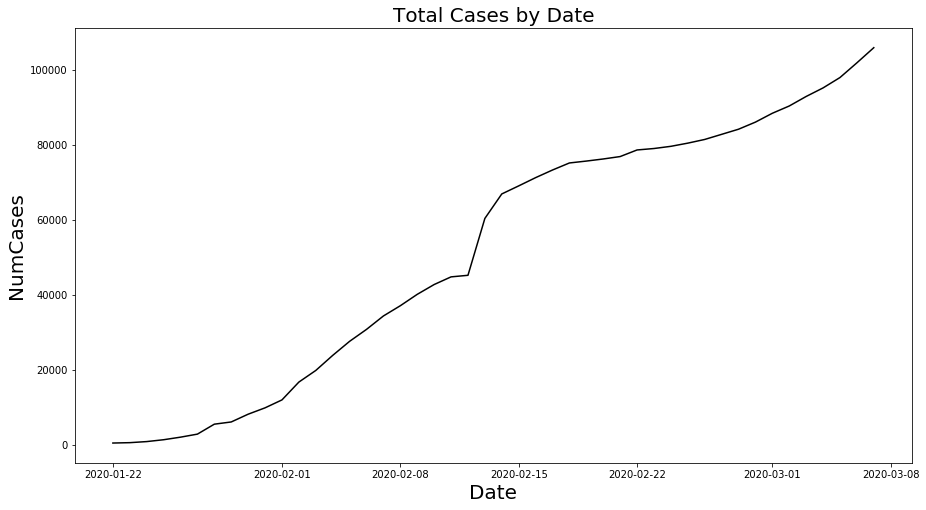

In [49]:
title = 'Increase in number of cases by day '
dff = df.groupby("date").agg({"cum_case" : "sum"}).reset_index()

x = dff["date"]
y = dff["cum_case"]
fig, ax = plt.subplots(figsize=(15, 8))
line, = ax.plot(x, y, color='k')
plt.xlabel('Date',fontsize=20)
plt.ylabel("NumCases", fontsize=20)
plt.title('Total Cases by Date', fontsize=20)


def animate(i):    
    line.set_data(x[:i], y[:i])
    
    ax.set_ylim(min(dff.cum_case), 150000)    
    ax.set_xlim(min(dff.date), max(dff.date))    
    ax.set_xticks([_ for i, _ in enumerate(dff.ObservationDate) if i%5 == 0])

    if len(list(x[:i])) > 0:
        key = list(x[:i])[-1]
        key += "\nCases: " + str(int(list(y[:i])[-1]))
        t = ax.text(0.9, 0.4, key, transform=ax.transAxes, color='#777777', size=25, ha='right', weight=400)   
        t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))


ani = animation.FuncAnimation(fig, animate, frames=(len)/dff, repeat=True)
ani.save('test1.gif', writer='imagemagick', fps=2)
plt.close(1)
filename = 'test1.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

### Top 10 countries outside China affected by nCoV

In [0]:
df_cases_no_china = df_last_update[(df_last_update['country'] != "China") & (df_last_update['country'] != "Mainland China")]
country_conf_max = []
country_reco_max = []
country_deth_max = []
country_val = []
for country, subset in df_cases_no_china.groupby('country'):
    country_conf_max.append(max(subset['cum_case']))
    country_reco_max.append(max(subset['cum_cured'])) 
    country_deth_max.append(max(subset['cum_death']))
    country_val.append(country)
df_country_woc = pd.DataFrame({"Country": country_val, "Confirmed":country_conf_max, "Recovered": country_reco_max, "Death": country_deth_max})
df_woc = df_country_woc.sort_values('Confirmed', ascending = False)
df_woc_top10 = df_woc.head(10)

In [31]:
df_woc[df_woc['Confirmed']>0][['Country','Confirmed','Recovered', "Death"]]

Country  Confirmed  Recovered  Death
86    South Korea       7041      135.0   44.0
44          Italy       5883      589.0  233.0
40           Iran       5823     1669.0  145.0
29         France        949       12.0   11.0
32        Germany        799       18.0    NaN
..            ...        ...        ...    ...
51      Lithuania          1        NaN    NaN
58         Monaco          1        NaN    NaN
60          Nepal          1        1.0    NaN
63        Nigeria          1        NaN    NaN
50  Liechtenstein          1        NaN    NaN

[101 rows x 4 columns]

In [38]:
fig = px.bar(df_country_woc[['Country', 'Confirmed']].sort_values('Confirmed', ascending=False), 
             y="Confirmed", x="Country", color='Country', 
             log_y=True, template='ggplot2', title='Confirmed Cases')
fig.show()

In [40]:
fig = px.bar(df_country_woc[['Country', 'Recovered']].sort_values('Recovered', ascending=False), 
             y="Recovered", x="Country", color='Country', 
             log_y=True, template='ggplot2', title='Recorvered Cases')
fig.show()

In [41]:
fig = px.bar(df_country_woc[['Country', 'Death']].sort_values('Death', ascending=False), 
             y="Death", x="Country", color='Country', 
             log_y=True, template='ggplot2', title='Death Cases')
fig.show()

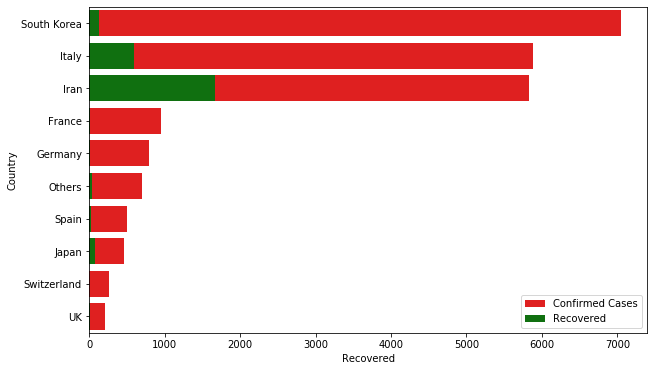

In [32]:
plt.figure(figsize=(10,6))
sns.barplot(x='Confirmed', y= 'Country', data = df_woc_top10, color='r', label='Confirmed Cases')
sns.barplot(x='Recovered', y= 'Country', data = df_woc_top10, color='g', label='Recovered')
plt.legend()
plt.show()